## 1. Import Libraries

In [29]:
import math
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings("ignore")

## 2. Load Train and Test Data

In [30]:
# Carga los datos desde los archivos guardados
X_train = np.load("data/X_train.npy")
y_train = np.load("data/y_train.npy")
X_test = np.load("data/X_test.npy")
y_test = np.load("data/y_test.npy")
scaler = joblib.load("data/scaler.pkl")
dates = np.load("data/dates.npy")
train_close_len = np.load("data/train_close_len.npy")

## 3. Designing our LSTM

### 3.1. Simple LSTM

In [15]:
# Modelo simple con una sola capa LSTM
model = Sequential()

# Capa LSTM sin return_sequences, para que solo devuelva la última salida
model.add(LSTM(units=512, activation='relu', input_shape=(X_train.shape[1], 1)))

# Capa densa final para predecir un único valor
model.add(Dense(units=1))

# Ver estructura del modelo
model.summary()

# Compilar el modelo
model.compile(optimizer="Adam", loss="mean_squared_error", metrics=['mae'])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 512)            │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,053,185 (4.02 MB)

 Trainable params: 1,053,185 (4.02 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Entrenar el modelo
model.fit(X_train, y_train,
          epochs=3,
          batch_size=100, 
          verbose=1)

Epoch 1/3
521/521 ━━━━━━━━━━━━━━━━━━━━ 198s 379ms/step - loss: 0.0024 - mae: 0.0167
Epoch 2/3
521/521 ━━━━━━━━━━━━━━━━━━━━ 189s 362ms/step - loss: 1.7862e-05 - mae: 0.0026
Epoch 3/3
521/521 ━━━━━━━━━━━━━━━━━━━━ 186s 356ms/step - loss: 1.6157e-05 - mae: 0.0025


In [ ]:
model.load_weights("weights/simple_layer_model.weights.h5")

In [12]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

408/408 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step


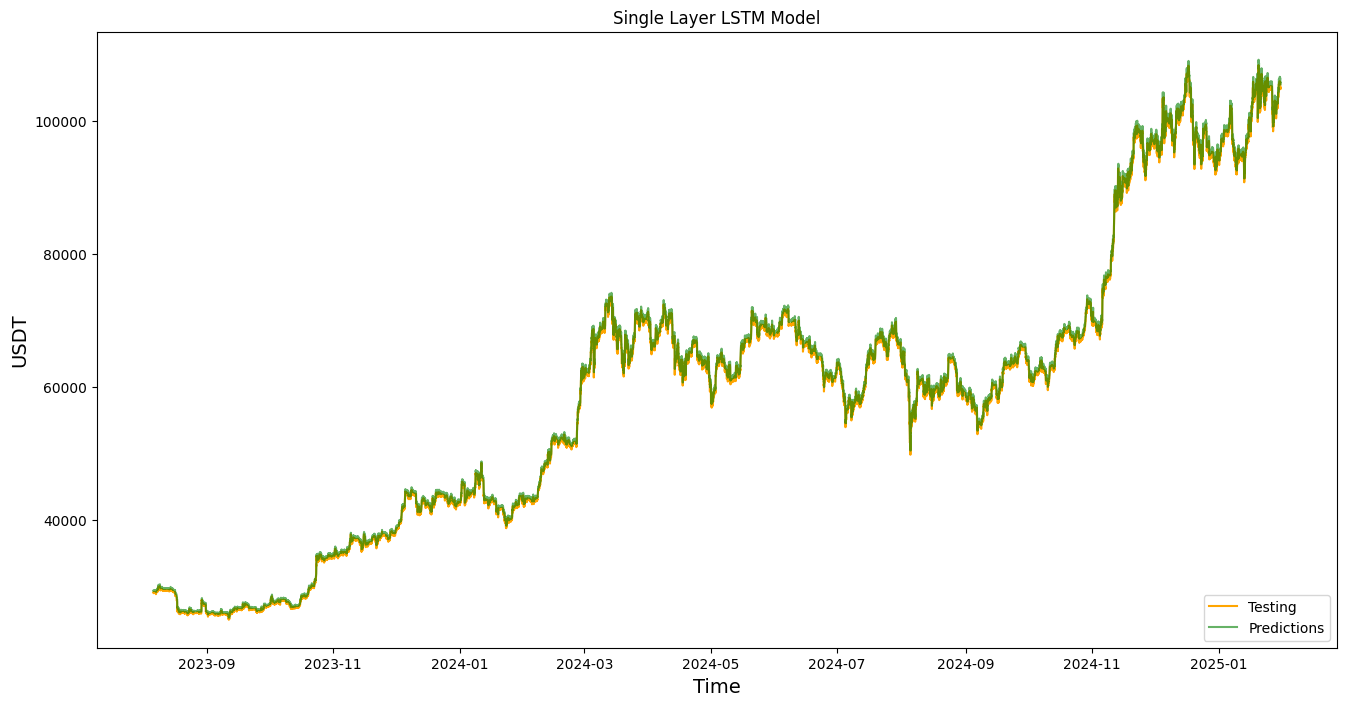

In [13]:
# plot the data
train = scaler.inverse_transform(y_train.reshape(-1, 1))
valid = scaler.inverse_transform(y_test.reshape(-1, 1))
#visualize the data
plt.figure(figsize=(16, 8))
plt.title("Single Layer LSTM Model")
plt.xlabel("Time", fontsize=14)
plt.ylabel("USDT", fontsize=14)
plt.plot(dates[train_close_len:], valid, color="orange")
plt.plot(dates[train_close_len:], predictions, alpha=0.6, color="green")
plt.legend(["Testing", "Predictions"], loc="lower right")
plt.show()

In [14]:
mse1 = np.mean(np.square(valid - predictions))
rmse1 = math.sqrt(mse1)
mae1 = np.mean(np.abs(valid - predictions))
print(f"Mean Squared Error: {mse1}")
print(f"Root Mean Squared Error: {rmse1}")
print(f"Mean Absolute Error: {mae1}")

Mean Squared Error: 378390.8701785318
Root Mean Squared Error: 615.1348390219268
Mean Absolute Error: 519.3379263197851


### 3.2. Double LSTM Layers

In [18]:
# Construye el modelo LSTM pre-optimizado
model = Sequential()

# Primera capa LSTM con 512 neuronas y salida de secuencia activada
model.add(LSTM(units=512, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], 1)))

# Segunda capa LSTM con 256 neuronas, sin devolver secuencias
model.add(LSTM(units=256, activation='relu', return_sequences=False))

# Capa densa final que genera la predicción
model.add(Dense(units=1))

# Muestra la estructura del modelo
model.summary()

# Compilar el modelo
model.compile(optimizer="Adam", loss="mean_squared_error", metrics=['mae'])

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 168, 512)       │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 256)            │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,840,385 (7.02 MB)

 Trainable params: 1,840,385 (7.02 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Entrenar el modelo
model.fit(X_train, y_train,
          epochs=3,
          batch_size=100, 
          verbose=1)

Epoch 1/3
521/521 ━━━━━━━━━━━━━━━━━━━━ 378s 724ms/step - loss: 0.0020 - mae: 0.0143
Epoch 2/3
521/521 ━━━━━━━━━━━━━━━━━━━━ 374s 718ms/step - loss: 2.7871e-05 - mae: 0.0033
Epoch 3/3
521/521 ━━━━━━━━━━━━━━━━━━━━ 376s 722ms/step - loss: 2.2098e-05 - mae: 0.0030


In [ ]:
model.load_weights("weights/double_layer_model.weights.h5")

In [20]:
popredictions = model.predict(X_test)
popredictions = scaler.inverse_transform(popredictions)

408/408 ━━━━━━━━━━━━━━━━━━━━ 39s 95ms/step


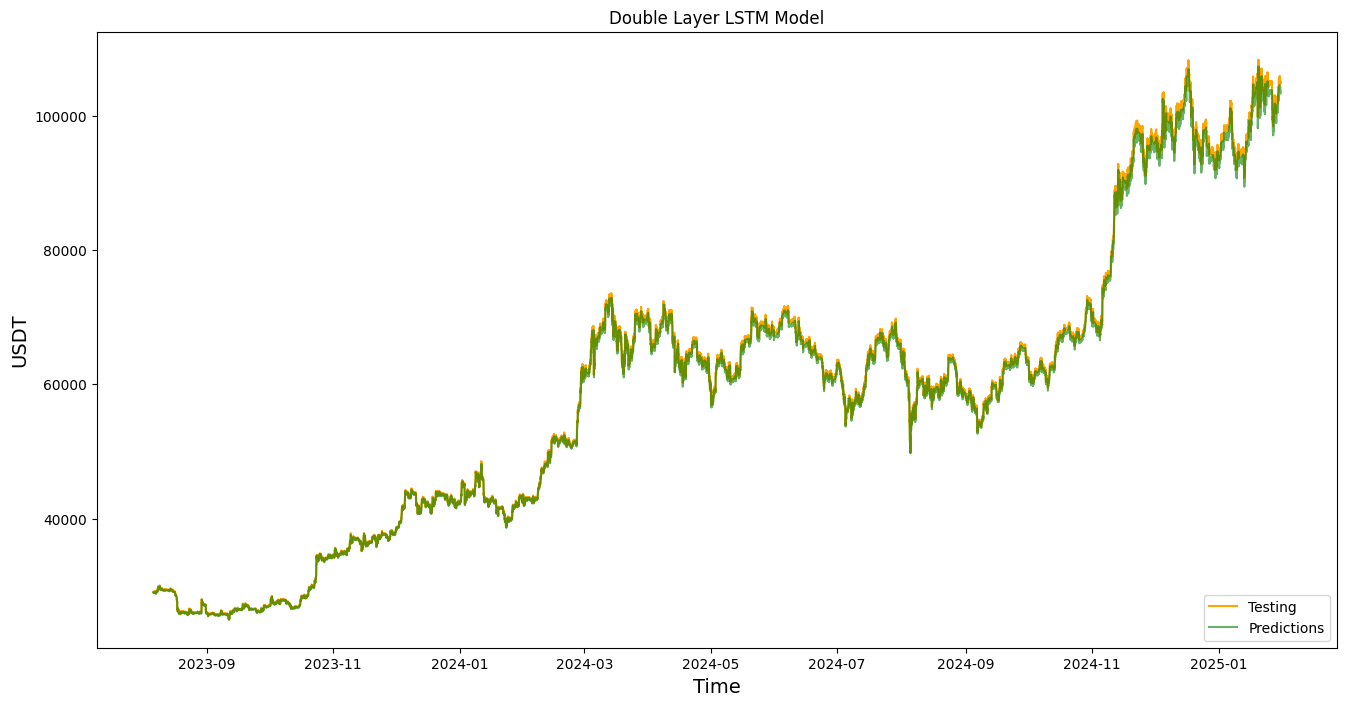

In [21]:
# plot the data
train = scaler.inverse_transform(y_train.reshape(-1, 1))
valid = scaler.inverse_transform(y_test.reshape(-1, 1))
#visualize the data
plt.figure(figsize=(16, 8))
plt.title("Double Layer LSTM Model")
plt.xlabel("Time", fontsize=14)
plt.ylabel("USDT", fontsize=14)
plt.plot(dates[train_close_len:], valid, color="orange")
plt.plot(dates[train_close_len:], popredictions, alpha=0.6, color="green")
plt.legend(["Testing", "Predictions"], loc="lower right")
plt.show()

In [22]:
mse2 = np.mean(np.square(valid - popredictions))
rmse2 = math.sqrt(mse2)
mae2 = np.mean(np.abs(valid - popredictions))
print(f"Mean Squared Error: {mse2}")
print(f"Root Mean Squared Error: {rmse2}")
print(f"Mean Absolute Error: {mae2}")

Mean Squared Error: 474600.2144009208
Root Mean Squared Error: 688.912341594285
Mean Absolute Error: 501.8646695987241


### 3.3. Optimized LSTM

In [31]:
# Construye el modelo LSTM optimizado
optimized_model = Sequential()

# Primera capa LSTM con 50 neuronas, manteniendo la salida de secuencia activa
optimized_model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))

# Segunda capa LSTM con 100 neuronas, sin devolver secuencias
optimized_model.add(LSTM(100, return_sequences=False))

# Capa densa intermedia con 50 neuronas
optimized_model.add(Dense(50))

# Capa densa final que genera la predicción
optimized_model.add(Dense(1))

# Muestra la estructura del modelo
optimized_model.summary()

# Compilar el modelo
optimized_model.compile(optimizer="adam", loss="mean_squared_error", metrics=['mae'])

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 168, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 100)            │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,901 (296.49 KB)

 Trainable params: 75,901 (296.49 KB)

 Non-trainable params: 0 (0.00 B)

In [91]:
# Entrenar el modelo
model.fit(X_train, y_train,
          epochs=3,
          batch_size=100, 
          verbose=1)

Epoch 1/3
521/521 ━━━━━━━━━━━━━━━━━━━━ 457s 877ms/step - loss: 9.6294e-06 - mae: 0.0019
Epoch 2/3
521/521 ━━━━━━━━━━━━━━━━━━━━ 409s 784ms/step - loss: 1.1356e-05 - mae: 0.0021
Epoch 3/3
521/521 ━━━━━━━━━━━━━━━━━━━━ 606s 1s/step - loss: 9.6696e-06 - mae: 0.0020


In [32]:
optimized_model.load_weights("weights/optimized_model.weights.h5")

In [33]:
# Predict with optimized LSTM model
o_predictions = optimized_model.predict(X_test)
o_predictions = scaler.inverse_transform(o_predictions)

408/408 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step


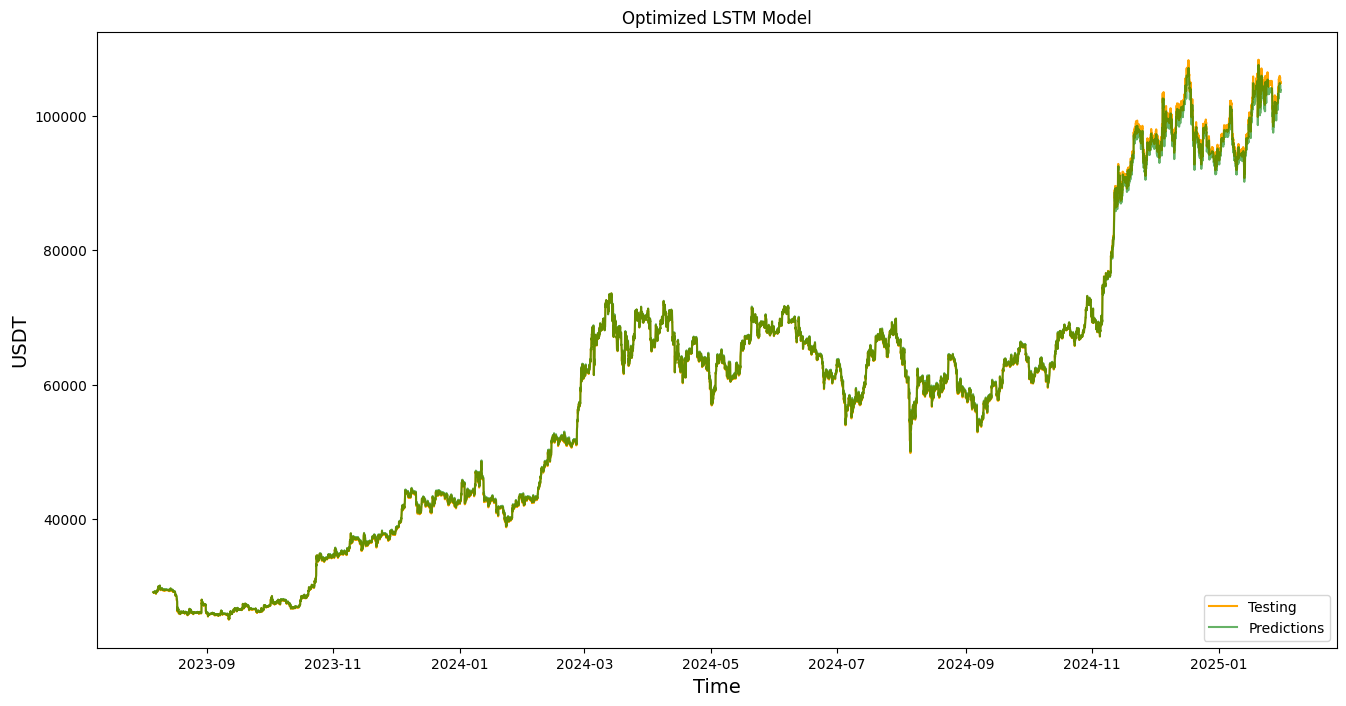

In [6]:
# plot the data
train = scaler.inverse_transform(y_train.reshape(-1, 1))
valid = scaler.inverse_transform(y_test.reshape(-1, 1))
#visualize the data
plt.figure(figsize=(16, 8))
plt.title("Optimized LSTM Model")
plt.xlabel("Time", fontsize=14)
plt.ylabel("USDT", fontsize=14)
plt.plot(dates[train_close_len:], valid, color="orange")
plt.plot(dates[train_close_len:], o_predictions, alpha=0.6, color="green")
plt.legend(["Testing", "Predictions"], loc="lower right")
plt.show()

In [7]:
mse3 = np.mean(np.square(valid - o_predictions))
rmse3 = math.sqrt(mse3)
mae3 = np.mean(np.abs(valid - o_predictions))
print(f"Mean Squared Error: {mse3}")
print(f"Root Mean Squared Error: {rmse3}")
print(f"Mean Absolute Error: {mae3}")

Mean Squared Error: 223740.08919247228
Root Mean Squared Error: 473.01172204552427
Mean Absolute Error: 296.33035380464975


## 4. Metrics Comparison

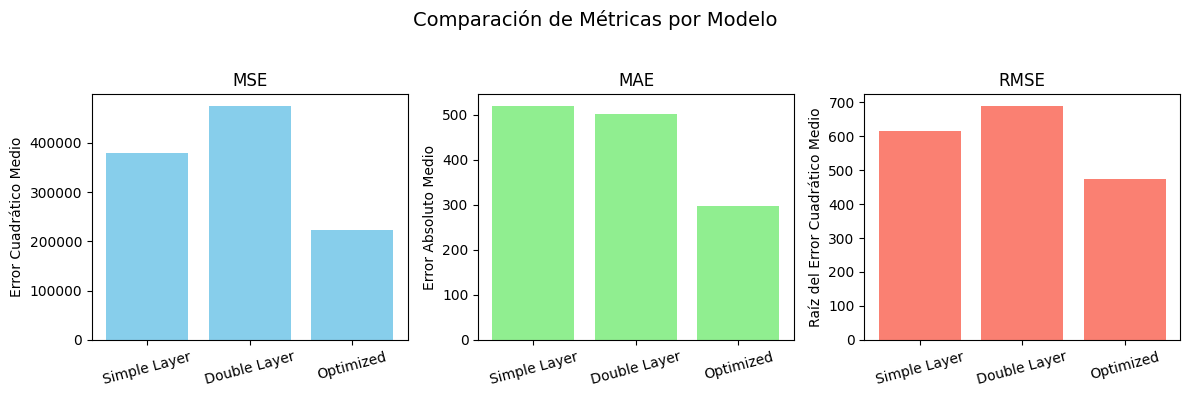

In [ ]:
# Listas organizadas con las métricas
mse = [mse1, mse2, mse3]
mae = [mae1, mae2, mae3]
rmse = [rmse1, rmse2, rmse3]

# Crear la figura y los subgráficos
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle("Comparación de Métricas por Modelo", fontsize=14)

# Modelos
modelos = ["Simple Layer", "Double Layer", "Optimized"]

# MSE
axes[0].bar(modelos, mse, color="skyblue")
axes[0].set_title("MSE")
axes[0].set_ylabel("Error Cuadrático Medio")

# MAE
axes[1].bar(modelos, mae, color="lightgreen")
axes[1].set_title("MAE")
axes[1].set_ylabel("Error Absoluto Medio")

# RMSE
axes[2].bar(modelos, rmse, color="salmon")
axes[2].set_title("RMSE")
axes[2].set_ylabel("Raíz del Error Cuadrático Medio")

# Ajustar etiquetas del eje x
for ax in axes:
    ax.set_xticklabels(modelos, rotation=15)

# Mostrar la gráfica
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## 5. Best Model Results

408/408 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step
Input del modelo:
[[0.25022075 0.25008299 0.25008603 ... 0.24842504 0.24811128 0.24832476]
 [0.25008299 0.25008603 0.25042455 ... 0.24811128 0.24832476 0.24851043]
 [0.25008603 0.25042455 0.25051952 ... 0.24832476 0.24851043 0.24823851]
 ...
 [0.95881263 0.95816292 0.95376335 ... 0.97524938 0.96762023 0.968965  ]
 [0.95816292 0.95376335 0.95174894 ... 0.96762023 0.968965   0.9693983 ]
 [0.95376335 0.95174894 0.9496779  ... 0.968965   0.9693983  0.96587253]] (13049, 168)
Output del modelo:
[[0.24888965]
 [0.24904916]
 [0.24880882]
 ...
 [0.95826274]
 [0.9582927 ]
 [0.9545497 ]] [[0.24888965]
 [0.24904916]
 [0.24880882]
 ...
 [0.95826274]
 [0.9582927 ]
 [0.9545497 ]]
Output real:
[0.24851043 0.24823851 0.24810958 ... 0.9693983  0.96587253 0.96753807] (13049,)


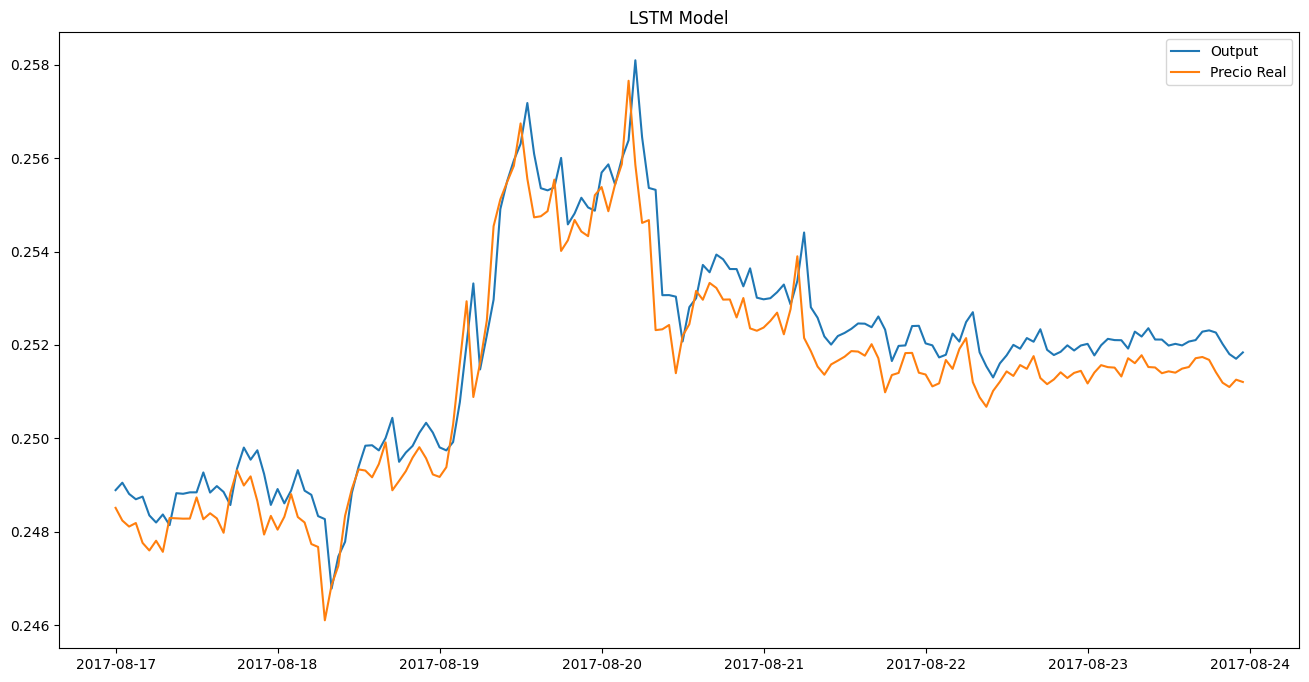

In [35]:
o_predictions_scaled = optimized_model.predict(X_test)

print('Input del modelo:')
print(X_test, X_test.shape)
print('Output del modelo:')
print(o_predictions_scaled, o_predictions_scaled)
print('Output real:')
print(y_test, y_test.shape)

plt.figure(figsize=(16, 8))
plt.title("LSTM Model")
plt.plot(dates[0:24*7], o_predictions_scaled[0:24*7], label="Output")
plt.plot(dates[0:24*7], y_test[0:24*7], label="Precio Real")
plt.legend(loc="best")
plt.show()